<a href="https://colab.research.google.com/github/nandhakumar-v-19/Rice-Leaf-Disease-using-CNN/blob/main/Rice_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    <h1><em><strong>Rice Leaf Disease Prediction</strong></em></h1>
</div>

This notebook covers these key objectives:
1. **Exploratory Data Analysis (EDA)** – understanding and validating the dataset.  
2. **Image Preprocessing** – preparing the data for training by resizing, normalizing, and augmenting.  
3. **CNN Model Setup** – defining the initial network architecture to ensure readiness for Day 2 training.  

---

### **Project Overview**
The dataset contains images of rice leaves affected by three common diseases:

- **Leaf Blast**  
- **Bacterial Blight**  
- **Brown Spot**

These categories are visually distinctive, enabling CNNs to learn discriminative texture and color features.  


# **Setup & Library Imports**

In [ ]:
!git clone https://github.com/nandhakumar-v-19/Rice-Leaf-Disease-using-CNN.git

fatal: destination path 'Rice-Leaf-Disease-using-CNN' already exists and is not an empty directory.


In [ ]:
# pip install -r /content/Rice-Leaf-Disease-using-CNN/requirements.txt
!pip install tensorflow

In [ ]:
# Step 1: Import the Required Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# **Exploratory Data Analysis (EDA)**

We begin by inspecting the dataset structure, counting images per class, and confirming that all images are readable and correctly labeled.

In [ ]:
# Define dataset path and list classes
data_dir = "/content/Rice-Leaf-Disease-using-CNN/RiceLeaf Dataset"

classes = os.listdir(data_dir)
print("Disease Classes:", classes)

Disease Classes: ['Leaf Smut', 'Brown spot', 'Bacterial leaf blight']


In [ ]:
 # Count the number of images per class
count_dict = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Create dataframe
df_counts = pd.DataFrame(list(count_dict.items()), columns=["Class Name", "Image Count"])

total = df_counts["Image Count"].sum()
df_counts["Percentage"] = (df_counts["Image Count"] / total * 100).round(2)

df_counts

,Class Name,Image Count,Percentage
0,Leaf Smut,39,32.77
1,Brown spot,40,33.61
2,Bacterial leaf blight,40,33.61


# **Sample Visualization**
Random samples help verify the variety and quality of the images for each disease class.

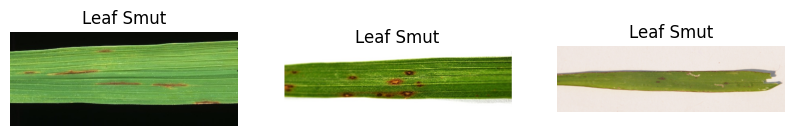

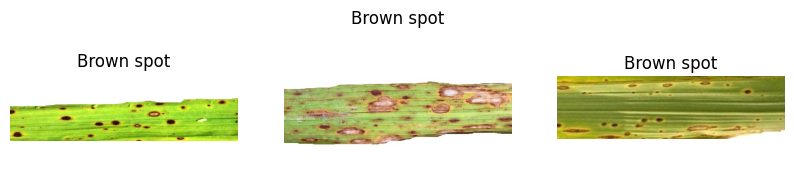

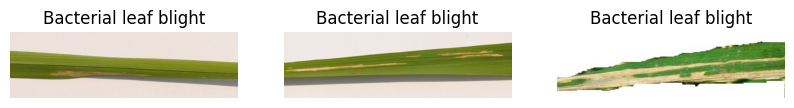

In [ ]:
import random
import matplotlib.pyplot as plt

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    sample_imgs = random.sample(os.listdir(class_path), 3)

    plt.figure(figsize=(10,3))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls)
    plt.show()

# **Class Distribution Visualization**
Understanding dataset balance ensures fair model training.

In [ ]:
print(df_counts.columns)

Index(['Class Name', 'Image Count', 'Percentage'], dtype='object')


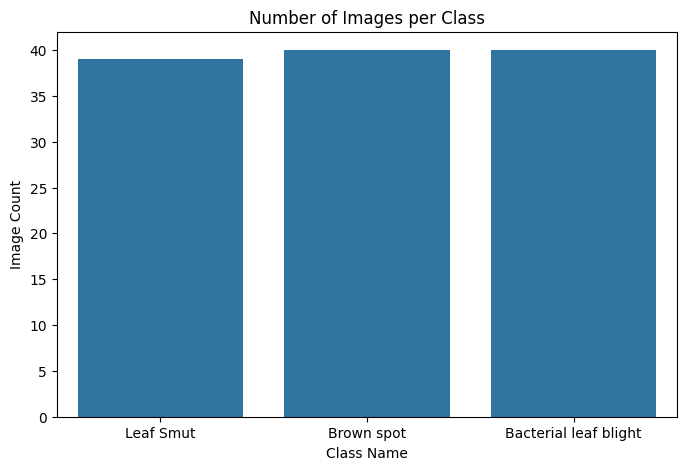

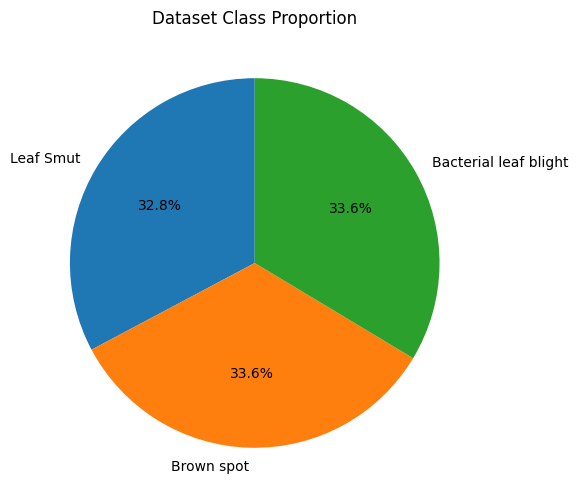

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x="Class Name", y="Image Count", data=df_counts)
plt.title("Number of Images per Class")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(df_counts["Image Count"], labels=df_counts["Class Name"], autopct="%1.1f%%", startangle=90)
plt.title("Dataset Class Proportion")
plt.show()


**Conclusion:** The Exploratory Data Analysis verifies that the Rice Leaf Disease dataset is ready for preprocessing and model development using Convolutional Neural Networks (CNN).

# **Data Integrity Check**
Verify that all image files are readable and none are corrupted.

In [ ]:
for cls in classes:
    folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            print(f"❌ Corrupted image found: {img_path}")
print("✅ All images verified successfully!")

✅ All images verified successfully!


# **Image Preprocessing & Augmentation**
After completing the Exploratory Data Analysis, we now prepare the dataset for model training.  
This step involves:
- Resizing images to a fixed dimension  
- Normalizing pixel values between 0 and 1  
- Applying **data augmentation** (rotation, flip, zoom) to increase diversity and improve generalization

We use Keras’s `ImageDataGenerator` to automate normalization and augmentation, while also splitting the dataset into **training** and **validation** subsets.

In [ ]:
!pip install tensorflow.keras

In [ ]:
# install and import the Required Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
# Create an ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixel values (0-1)
    rotation_range=30,     # random rotation
    horizontal_flip=True,  # flip images horizontally
    zoom_range=0.2,        # zoom randomly
    validation_split=0.2   # 80% train, 20% validation
)
display(datagen)

In [ ]:
# Load training and validation data from folders
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


# **Visualizing Augmented Images**
We can visualize a few augmented samples generated in real-time during training.  
This helps confirm that the transformations (rotations, flips, zooms) are applied correctly and the features remain intact.

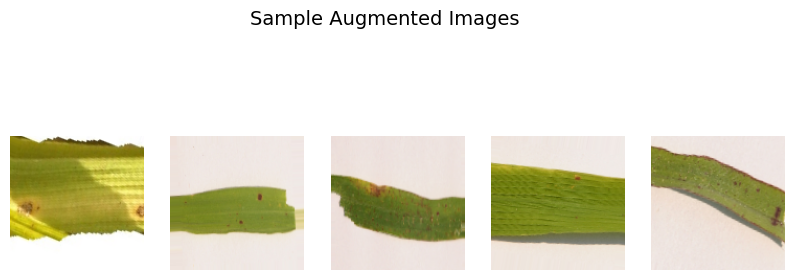

In [ ]:
# Display a few augmented samples
x_batch, y_batch = next(train_data)
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.axis("off")
plt.suptitle("Sample Augmented Images", fontsize=14)
plt.show()

# **CNN Model Architecture Setup**

With the data ready, we now define our **Convolutional Neural Network (CNN)** architecture.  
The CNN will automatically learn spatial features from the images — such as patterns, edges, and textures — that distinguish between the disease classes.

This base model consists of:
- Two convolutional layers for feature extraction  
- Two max-pooling layers for spatial downsampling  
- One fully connected (dense) layer for decision-making  
- A softmax output layer for classification into 3 categories


In [ ]:
!pip install tensorflow.keras

In [ ]:
from tensorflow.keras import layers, models

# Define the CNN architecture
model = models.Sequential([

    # Input layer
    layers.Input(shape=(128,128,3)),  # 👈 Define input here

    # Convolution + Pooling Block 1
    layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),

    # Convolution + Pooling Block 2
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),

    # Convolution + Pooling Block 3
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer (3 classes)
    layers.Dense(3, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Train the Model
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4596 - loss: 0.9153 - val_accuracy: 0.5217 - val_loss: 1.1614
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5729 - loss: 0.8855 - val_accuracy: 0.6087 - val_loss: 0.9279
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6445 - loss: 0.8042 - val_accuracy: 0.5217 - val_loss: 1.7413
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5911 - loss: 0.8743 - val_accuracy: 0.5652 - val_loss: 0.8174
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6042 - loss: 0.8281 - val_accuracy: 0.6957 - val_loss: 1.1081
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6810 - loss: 0.8115 - val_accuracy: 0.5217 - val_loss: 1.0194
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5547 - loss: 0.7898 - val_accuracy: 0.6522 - val_loss: 0.9447
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5833 - loss: 0.8257 - val_accuracy: 0.7391 - val_loss: 0.8860
Epoch 9/10
3/3 ━

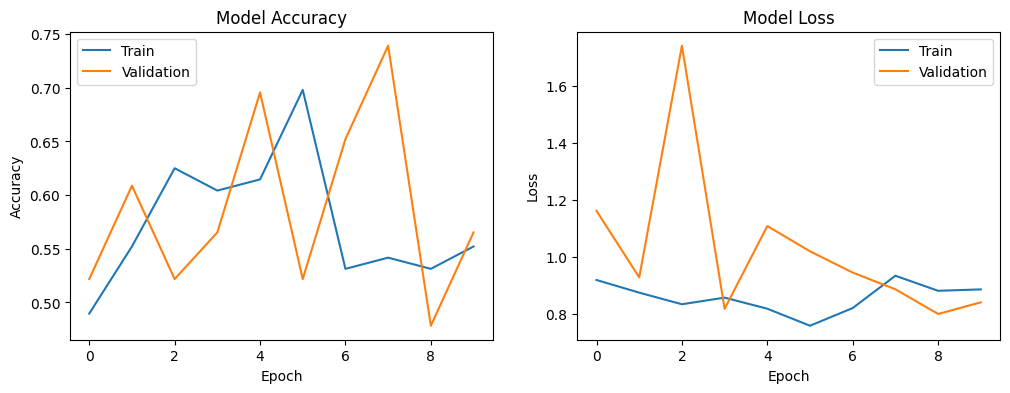

In [ ]:
# Training Curves
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

plt.show()


In [ ]:
#Evaluate Model
loss, accuracy = model.evaluate(val_data)
print("Validation Accuracy:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.7391 - loss: 0.8328
Validation Accuracy: 0.739130437374115


In [ ]:
model.save("rice_leaf_model.h5")
print(" Model Saved Successfully!")


 Model Saved Successfully!
